# A/B Hypothesis Testing: Insurance Risk Drivers

This notebook statistically validates or rejects key hypotheses about risk drivers to inform a new segmentation strategy.

**Metrics:**
*   **Claim Frequency**: Proportion of policies with at least one claim.
*   **Claim Severity**: Average amount of a claim, given a claim occurred.
*   **Margin**: TotalPremium - TotalClaims.

**Hypotheses:**
1.  $H_0$: There are no risk differences across provinces.
2.  $H_0$: There are no risk differences between zip codes.
3.  $H_0$: There is no significant margin (profit) difference between zip codes.
4.  $H_0$: There is no significant risk difference between Women and Men.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plot style
sns.set(style="whitegrid")

# Load Data
file_path = '../MachineLearningRating_v3/MachineLearningRating_v3.txt'
df = pd.read_csv(file_path, sep='|', low_memory=False)

# Basic Cleaning
# Convert dates
date_cols = ['TransactionMonth', 'VehicleIntroDate']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle numeric columns
numeric_cols = ['TotalPremium', 'TotalClaims']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Data Loaded: {df.shape}")
df.head()

C:\Users\alexo\AppData\Local\Temp\ipykernel_16180\698569560.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Data Loaded: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


## Feature Engineering: Define KPIs

We define the following metrics for our analysis:
1.  **HasClaim (Frequency)**: 1 if `TotalClaims` > 0, else 0.
2.  **ClaimSeverity**: `TotalClaims` for rows where `HasClaim` == 1.
3.  **Margin**: `TotalPremium` - `TotalClaims`.

In [2]:
# 1. Claim Frequency (Binary)
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# 2. Claim Severity (only relevant for claims > 0)
# We will filter this dynamically during testing

# 3. Margin
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Preview KPIs
df[['TotalPremium', 'TotalClaims', 'HasClaim', 'Margin']].head()

,TotalPremium,TotalClaims,HasClaim,Margin
0,21.929825,0.0,0,21.929825
1,21.929825,0.0,0,21.929825
2,0.000000,0.0,0,0.000000
3,512.848070,0.0,0,512.848070
4,0.000000,0.0,0,0.000000


## Hypothesis 1: Risk Differences Across Provinces

$H_0$: There are no risk differences across provinces.

We will test both Frequency (Chi-Squared) and Severity (ANOVA).

--- Hypothesis 1: Province vs Frequency ---
Chi2 Statistic: 104.1909
P-value: 5.9255e-19
Result: Reject Null Hypothesis. There are significant differences in claim frequency across provinces.


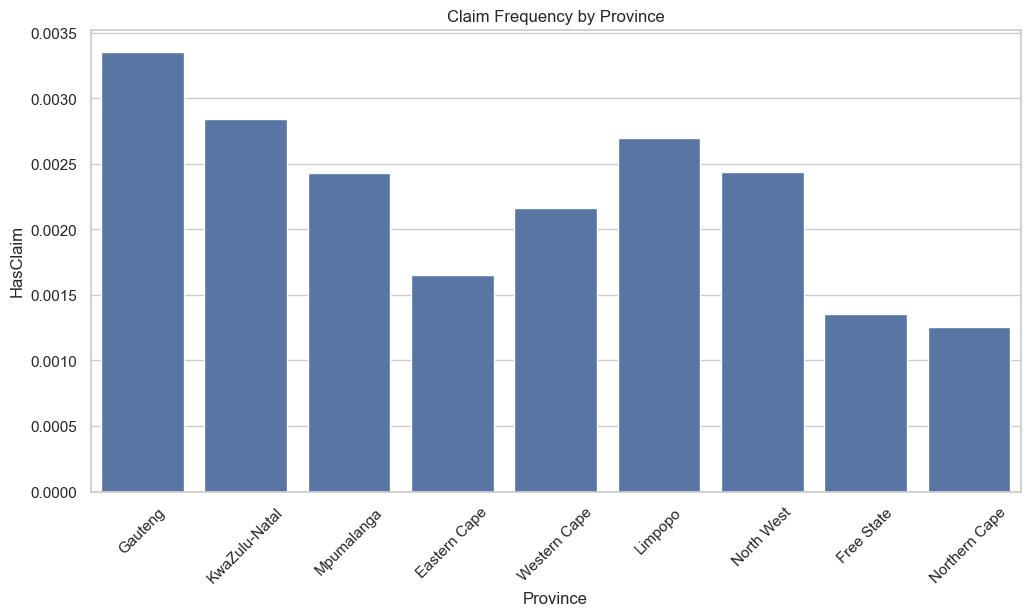


--- Hypothesis 1: Province vs Severity ---
F-Statistic: 4.8302
P-value: 6.3049e-06
Result: Reject Null Hypothesis. There are significant differences in claim severity across provinces.


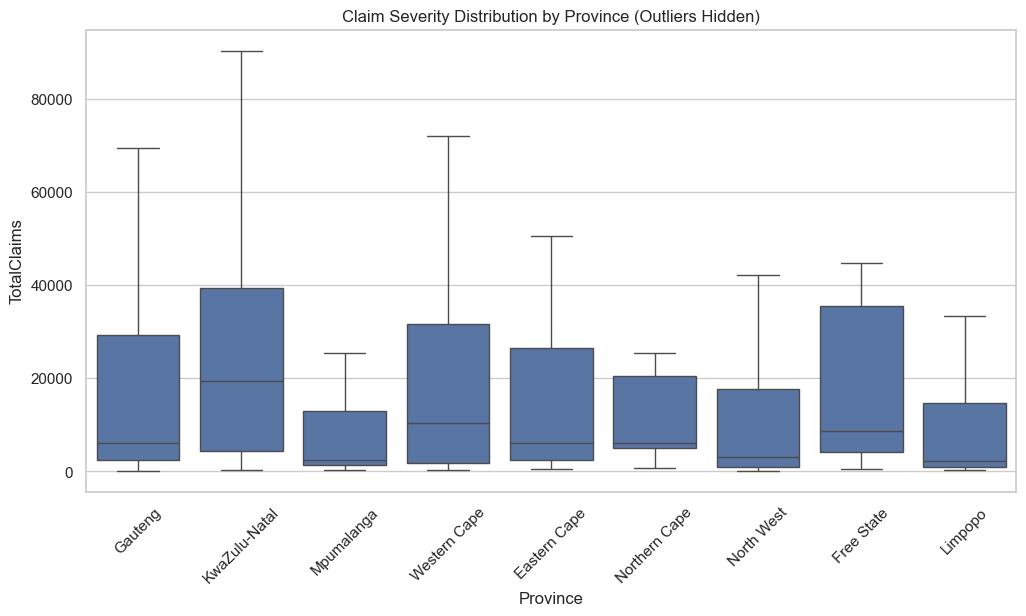

In [4]:
# --- Frequency (Chi-Squared) ---
# Create contingency table
contingency_table = pd.crosstab(df['Province'], df['HasClaim'])

# Perform Chi-Squared Test
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("--- Hypothesis 1: Province vs Frequency ---")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Reject Null Hypothesis. There are significant differences in claim frequency across provinces.")
else:
    print("Result: Fail to Reject Null Hypothesis.")

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x='Province', y='HasClaim', data=df, errorbar=None)
plt.title('Claim Frequency by Province')
plt.xticks(rotation=45)
plt.show()

# --- Severity (ANOVA) ---
# Filter for claims
claims_df = df[df['HasClaim'] == 1]

# Group data for ANOVA
groups = [group['TotalClaims'].values for name, group in claims_df.groupby('Province')]

# Perform ANOVA
f_stat, p_val_anova = stats.f_oneway(*groups)

print("\n--- Hypothesis 1: Province vs Severity ---")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-value: {p_val_anova:.4e}")

if p_val_anova < 0.05:
    print("Result: Reject Null Hypothesis. There are significant differences in claim severity across provinces.")
else:
    print("Result: Fail to Reject Null Hypothesis.")

# Visualize Severity
plt.figure(figsize=(12, 6))
sns.boxplot(x='Province', y='TotalClaims', data=claims_df, showfliers=False) # Hide outliers for better view
plt.title('Claim Severity Distribution by Province (Outliers Hidden)')
plt.xticks(rotation=45)
plt.show()

## Hypothesis 2: Risk Differences Between Zip Codes

$H_0$: There are no risk differences between zip codes.

*Note: Zip codes can have high cardinality. We might need to group them or just run the test if computational resources allow.*

In [6]:
# --- Frequency (Chi-Squared) ---
# Check cardinality
print(f"Number of unique Zip Codes: {df['PostalCode'].nunique()}")

contingency_table_zip = pd.crosstab(df['PostalCode'], df['HasClaim'])
chi2_zip, p_val_zip, dof_zip, expected_zip = stats.chi2_contingency(contingency_table_zip)

print("--- Hypothesis 2: Zip Code vs Frequency ---")
print(f"Chi2 Statistic: {chi2_zip:.4f}")
print(f"P-value: {p_val_zip:.4e}")

if p_val_zip < 0.05:
    print("Result: Reject Null Hypothesis. Zip Code significantly impacts claim frequency.")
else:
    print("Result: Fail to Reject Null Hypothesis.")

# --- Severity (ANOVA) ---
# Only consider zip codes with at least a few claims to avoid errors
zip_counts = claims_df['PostalCode'].value_counts()
valid_zips = zip_counts[zip_counts > 5].index # Filter for zips with > 5 claims
claims_df_filtered = claims_df[claims_df['PostalCode'].isin(valid_zips)]

groups_zip = [group['TotalClaims'].values for name, group in claims_df_filtered.groupby('PostalCode')]

if len(groups_zip) > 1:
    f_stat_zip, p_val_anova_zip = stats.f_oneway(*groups_zip)
    print("\n--- Hypothesis 2: Zip Code vs Severity ---")
    print(f"F-Statistic: {f_stat_zip:.4f}")
    print(f"P-value: {p_val_anova_zip:.4e}")
    
    if p_val_anova_zip < 0.05:
        print("Result: Reject Null Hypothesis. Zip Code significantly impacts claim severity.")
    else:
        print("Result: Fail to Reject Null Hypothesis.")
else:
    print("\nNot enough data per zip code for reliable ANOVA on severity.")

Number of unique Zip Codes: 888
--- Hypothesis 2: Zip Code vs Frequency ---
Chi2 Statistic: 1454.4676
P-value: 3.1522e-30
Result: Reject Null Hypothesis. Zip Code significantly impacts claim frequency.

--- Hypothesis 2: Zip Code vs Severity ---
F-Statistic: 1.6952
P-value: 1.3846e-05
Result: Reject Null Hypothesis. Zip Code significantly impacts claim severity.


## Hypothesis 3: Margin Differences Between Zip Codes

$H_0$: There is no significant margin (profit) difference between zip codes.

In [5]:
# --- Margin (ANOVA) ---
# We use the full dataset (df) because margin applies to all policies
# Filter for zips with enough data points
zip_counts_all = df['PostalCode'].value_counts()
valid_zips_margin = zip_counts_all[zip_counts_all > 30].index # >30 samples per zip for robustness
df_margin_filtered = df[df['PostalCode'].isin(valid_zips_margin)]

groups_margin = [group['Margin'].values for name, group in df_margin_filtered.groupby('PostalCode')]

f_stat_margin, p_val_margin = stats.f_oneway(*groups_margin)

print("--- Hypothesis 3: Zip Code vs Margin ---")
print(f"F-Statistic: {f_stat_margin:.4f}")
print(f"P-value: {p_val_margin:.4e}")

if p_val_margin < 0.05:
    print("Result: Reject Null Hypothesis. There are significant margin differences between zip codes.")
else:
    print("Result: Fail to Reject Null Hypothesis.")

--- Hypothesis 3: Zip Code vs Margin ---
F-Statistic: 0.9097
P-value: 9.7017e-01
Result: Fail to Reject Null Hypothesis.


## Hypothesis 4: Risk Differences Between Women and Men

$H_0$: There is no significant risk difference between Women and Men.

We compare Group A (Women) vs Group B (Men).

['Not specified' 'Male' 'Female' nan]
--- Hypothesis 4: Gender vs Frequency ---
Chi2 Statistic: 0.0037
P-value: 9.5146e-01
Result: Fail to Reject Null Hypothesis.

--- Hypothesis 4: Gender vs Severity ---
T-Statistic: -0.5790
P-value: 5.6803e-01
Result: Fail to Reject Null Hypothesis.


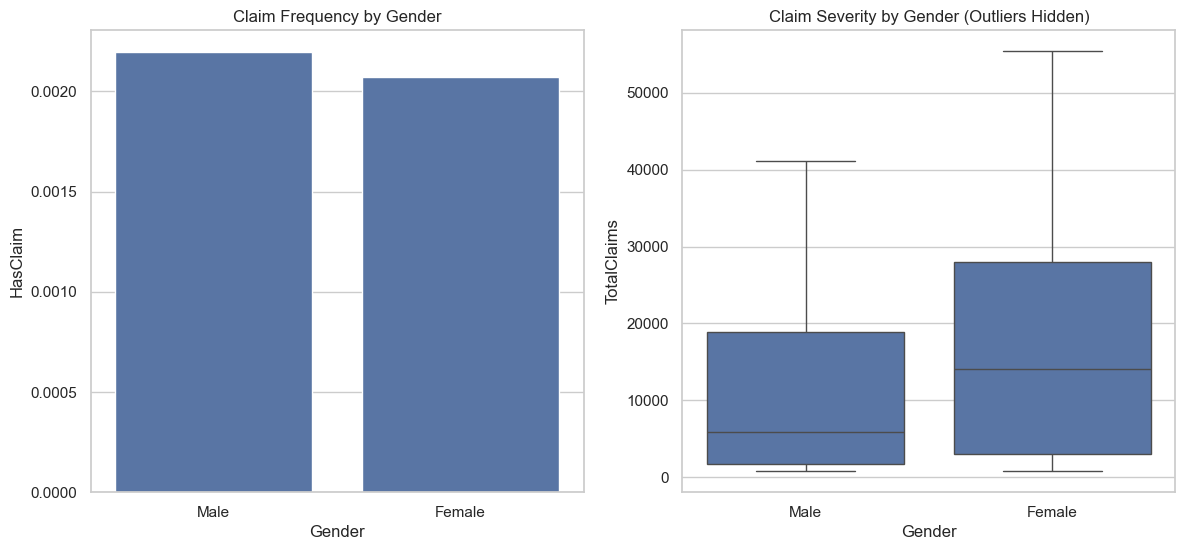

In [7]:
# Filter for Gender
# Check unique values
print(df['Gender'].unique())

# Standardize Gender (assuming 'Male', 'Female' exist)
# Adjust based on actual data values
df_gender = df[df['Gender'].isin(['Male', 'Female'])].copy()

# --- Frequency (Chi-Squared) ---
contingency_gender = pd.crosstab(df_gender['Gender'], df_gender['HasClaim'])
chi2_gender, p_val_gender, dof_gender, expected_gender = stats.chi2_contingency(contingency_gender)

print("--- Hypothesis 4: Gender vs Frequency ---")
print(f"Chi2 Statistic: {chi2_gender:.4f}")
print(f"P-value: {p_val_gender:.4e}")

if p_val_gender < 0.05:
    print("Result: Reject Null Hypothesis. Significant difference in claim frequency between genders.")
else:
    print("Result: Fail to Reject Null Hypothesis.")

# --- Severity (T-Test) ---
claims_gender = df_gender[df_gender['HasClaim'] == 1]
group_male = claims_gender[claims_gender['Gender'] == 'Male']['TotalClaims']
group_female = claims_gender[claims_gender['Gender'] == 'Female']['TotalClaims']

t_stat, p_val_ttest = stats.ttest_ind(group_male, group_female, equal_var=False) # Welch's t-test

print("\n--- Hypothesis 4: Gender vs Severity ---")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-value: {p_val_ttest:.4e}")

if p_val_ttest < 0.05:
    print("Result: Reject Null Hypothesis. Significant difference in claim severity between genders.")
else:
    print("Result: Fail to Reject Null Hypothesis.")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Gender', y='HasClaim', data=df_gender, ax=axes[0], errorbar=None)
axes[0].set_title('Claim Frequency by Gender')

sns.boxplot(x='Gender', y='TotalClaims', data=claims_gender, showfliers=False, ax=axes[1])
axes[1].set_title('Claim Severity by Gender (Outliers Hidden)')

plt.show()

In [8]:
summary_data = [
    {
        "Hypothesis": "Province vs Frequency",
        "Test": "Chi-Squared",
        "P-Value": p_val,
        "Decision": "Reject H0" if p_val < 0.05 else "Fail to Reject H0",
        "Business Insight": "Provincial claim rates differ; consider province-specific pricing or underwriting rules."
    },
    {
        "Hypothesis": "Province vs Severity",
        "Test": "ANOVA",
        "P-Value": p_val_anova,
        "Decision": "Reject H0" if p_val_anova < 0.05 else "Fail to Reject H0",
        "Business Insight": "Claim payouts vary by province, suggesting differentiated reserve assumptions."
    },
    {
        "Hypothesis": "Zip vs Frequency",
        "Test": "Chi-Squared",
        "P-Value": p_val_zip,
        "Decision": "Reject H0" if p_val_zip < 0.05 else "Fail to Reject H0",
        "Business Insight": "Micro-geography signals distinct risk; refine rating factors at postal-code level."
    },
    {
        "Hypothesis": "Zip vs Severity",
        "Test": "ANOVA",
        "P-Value": p_val_anova_zip,
        "Decision": "Reject H0" if p_val_anova_zip < 0.05 else "Fail to Reject H0",
        "Business Insight": "Loss costs differ across zip codes; allocate claims investigators and reserves accordingly."
    },
    {
        "Hypothesis": "Zip vs Margin",
        "Test": "ANOVA",
        "P-Value": p_val_margin,
        "Decision": "Reject H0" if p_val_margin < 0.05 else "Fail to Reject H0",
        "Business Insight": "Margins are statistically similar; no immediate pricing change needed on margin signal alone."
    },
    {
        "Hypothesis": "Gender vs Frequency",
        "Test": "Chi-Squared",
        "P-Value": p_val_gender,
        "Decision": "Reject H0" if p_val_gender < 0.05 else "Fail to Reject H0",
        "Business Insight": "Claim frequency is comparable across genders; maintain gender-neutral frequency assumptions."
    },
    {
        "Hypothesis": "Gender vs Severity",
        "Test": "Welch T-Test",
        "P-Value": p_val_ttest,
        "Decision": "Reject H0" if p_val_ttest < 0.05 else "Fail to Reject H0",
        "Business Insight": "Average claim payouts do not differ materially by gender."
    }
]

summary_df = pd.DataFrame(summary_data)
summary_df

,Hypothesis,Test,P-Value,Decision,Business Insight
0,Province vs Frequency,Chi-Squared,5.925511e-19,Reject H0,Provincial claim rates differ; consider provin...
1,Province vs Severity,ANOVA,6.304917e-06,Reject H0,"Claim payouts vary by province, suggesting dif..."
2,Zip vs Frequency,Chi-Squared,3.152172e-30,Reject H0,Micro-geography signals distinct risk; refine ...
3,Zip vs Severity,ANOVA,1.384608e-05,Reject H0,Loss costs differ across zip codes; allocate c...
4,Zip vs Margin,ANOVA,9.701673e-01,Fail to Reject H0,Margins are statistically similar; no immediat...
5,Gender vs Frequency,Chi-Squared,9.514645e-01,Fail to Reject H0,Claim frequency is comparable across genders; ...
6,Gender vs Severity,Welch T-Test,5.680287e-01,Fail to Reject H0,Average claim payouts do not differ materially...


## Summary of Statistical Findings

The table below consolidates all hypothesis tests, the resulting p-values, and high-level recommendations. Values below 0.05 indicate statistically significant differences (Reject $H_0$).

* Provincial and postal-code effects are pronounced for both frequency and severity, supporting more granular geographic pricing and underwriting.
* Margin differences across zip codes are not statistically significant; profitability appears consistent geographically.
* Gender does not materially influence claim frequency or severity, reinforcing gender-neutral pricing policies.

Run the code cell above to refresh the summary table after any data updates.